In [1]:
import pandas as pd
import numpy as np
import json
import warnings
import spacy
warnings.filterwarnings("ignore")
import random

import nltk
from nltk.stem import WordNetLemmatizer

import re

from spacy.tokens import DocBin

from tqdm import tqdm

from sklearn.model_selection import train_test_split

In [2]:
train_data = pd.read_csv(r"C:\Users\sai\Desktop\PRAXIS\Term - 3\CAPP\Datasets\train.csv")
features = pd.read_csv(r"C:\Users\sai\Desktop\PRAXIS\Term - 3\CAPP\Datasets\features.csv")
patient_notes = pd.read_csv(r"C:\Users\sai\Desktop\PRAXIS\Term - 3\CAPP\Datasets\patient_notes.csv")

### CASE - 2

In [3]:
case_2_features = features[features["case_num"] == 2]
case_2_features

,feature_num,case_num,feature_text
26,200,2,Prior-normal-periods
27,201,2,Last-Pap-smear-I-year-ago
28,202,2,IUD
29,203,2,Sexually-active
30,204,2,Vaginal-dryness
31,205,2,Irregular-menses
32,206,2,Recent-nausea-vomiting-OR-Recent-flulike-symptoms
33,207,2,No-premenstrual-symptoms
34,208,2,Female
35,209,2,Stress


In [4]:
case_2_pn = patient_notes[patient_notes["case_num"] ==  2]
case_2_pn

,pn_num,case_num,pn_history
3076,20000,2,44 yo F. C/o irregular mestrual periods. prev...
3077,20001,2,CC: 44 yo female c/o irregular periods\r\nHPI:...
3078,20002,2,"Dolores Montgomery, a 44-year-old female, has ..."
3079,20003,2,HPI: 44 yo female presenting with menstrual ir...
3080,20004,2,CC: irregular mentrual bleeding \r\n44 yo F G2...
...,...,...,...
5029,22137,2,"44 y/o F, c/o irregular menstrual periods. It ..."
5030,22138,2,Ms. Montgomery is a 44 y/o F who presents with...
5031,22139,2,44 yo female complains of irregular periods fo...
5032,22140,2,a 44 y o f comes to clinic to for irregular pe...


In [5]:
case_2_train = train_data[train_data["case_num"] == 2]
case_2_train = case_2_train[case_2_train.annotation != '[]']
case_2_train

,id,case_num,pn_num,feature_num,annotation,location
2604,20001_204,2,20001,204,"['vaginal dryness', 'dryness which she uses lu...","['465 480', '473 509']"
2605,20001_205,2,20001,205,"['irregular periods', 'irregular periods']","['21 38', '63 80']"
2606,20001_206,2,20001,206,"['one week ago with nausea and vomiting', 'flu...","['238 275', '220 250']"
2608,20001_208,2,20001,208,['female'],['10 16']
2610,20001_210,2,20001,210,['LMP was 2 months ago'],['129 149']
...,...,...,...,...,...,...
4294,22123_211,2,22123,211,['hot flashes'],['349 360']
4295,22123_212,2,22123,212,"['1 or more elements (bleeding, duration) chan...","['172 235', '262 280', '237 260']"
4296,22123_213,2,22123,213,['3 year history of'],['18 35']
4297,22123_214,2,22123,214,"['sweating', 'sweating']","['318 326', '365 373']"


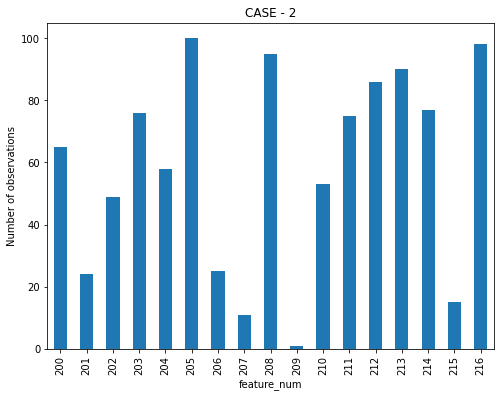

In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize=[8,6])
case_2_train.groupby("feature_num").size().plot.bar()
plt.title("CASE - 2")
plt.ylabel("Number of observations")
plt.show()

In [7]:
# 201(25), 206(25), 207(11), 215(19)

### Over Sampling for CASE - 2

In [8]:
pn_dict = {}
for idx, row in case_2_pn.iterrows():
    pn_dict[row['pn_num']] = row['pn_history']

In [9]:
new_annotation = []
for case_id in case_2_features['case_num'].unique():
    
    all_pn_id = set(case_2_pn[case_2_pn['case_num']==case_id]['pn_num'].tolist())
    
    for feature_id in case_2_features[case_2_features['case_num']==case_id]['feature_num'].unique():
        # get all the pn_num that have already been annotated
        annotated_pn = set(case_2_train[case_2_train['feature_num']==feature_id]['pn_num'].tolist())
        # get all the pn_num that have NOT been annotated
        pn_to_annotate = all_pn_id-annotated_pn
        
        # get all current annotations
        # we will use them to find more annotations
        annotations = case_2_train[case_2_train['feature_num']==feature_id]['annotation'].tolist()
        annotation_texts = set()
        for a in annotations:
            anns = eval(a)
            for at in anns:
                annotation_texts.add(at)
                
        # annotate       
        for pn_id in pn_to_annotate:
            new_annotation_pn, new_location_pn = [], []
            pn_text = pn_dict[pn_id]
            for at in annotation_texts:
                start = pn_text.find(at)
                if start>=0:
                    new_annotation_pn.append(at)
                    new_location_pn.append(f'{start} {start+len(at)}')
            if len(new_annotation_pn)>0:
                new_annotation.append((
                    f'{pn_id:04d}_{feature_id:03d}',
                    case_id,
                    pn_id,
                    feature_id,
                    new_annotation_pn,
                    new_location_pn
                ))
     #   break
    break
    # break to get sample results quickly

In [10]:
len(new_annotation)

15224

In [11]:
df=pd.DataFrame(new_annotation)
df.head()

,0,1,2,3,4,5
0,20481_200,2,20481,200,[periods were regular],[117 137]
1,20489_200,2,20489,200,"[Prior to this she had regular periods, had re...","[107 144, 125 144]"
2,20493_200,2,20493,200,[periods were regular],[594 614]
3,20496_200,2,20496,200,[had regular periods],[117 136]
4,20499_200,2,20499,200,[periods were regular],[303 323]


In [12]:
df.columns=['id','case_num','pn_num','feature_num','annotation','location']
df.head()

,id,case_num,pn_num,feature_num,annotation,location
0,20481_200,2,20481,200,[periods were regular],[117 137]
1,20489_200,2,20489,200,"[Prior to this she had regular periods, had re...","[107 144, 125 144]"
2,20493_200,2,20493,200,[periods were regular],[594 614]
3,20496_200,2,20496,200,[had regular periods],[117 136]
4,20499_200,2,20499,200,[periods were regular],[303 323]


In [13]:
df["location"] = df["location"].apply(str)
df["annotation"] = df["annotation"].apply(str)

df["annotation"] = df.annotation.str.replace('[','')
df["annotation"] = df.annotation.str.replace(']','')
df["location"] = df.location.str.replace('[','')
df["location"] = df.location.str.replace(']','')

df.head()

,id,case_num,pn_num,feature_num,annotation,location
0,20481_200,2,20481,200,'periods were regular','117 137'
1,20489_200,2,20489,200,"'Prior to this she had regular periods', 'had ...","'107 144', '125 144'"
2,20493_200,2,20493,200,'periods were regular','594 614'
3,20496_200,2,20496,200,'had regular periods','117 136'
4,20499_200,2,20499,200,'periods were regular','303 323'


In [14]:
# 201(25), 206(25), 207(11), 215(19)

In [15]:
df = df[(df["feature_num"] == 200)|(df["feature_num"] == 201)|(df["feature_num"] == 203)|(df["feature_num"] == 206)|(df["feature_num"] == 207)|(df["feature_num"] == 215)|(df["feature_num"] == 216)][['pn_num','annotation',"location","feature_num"]]
df.shape

(3984, 4)

In [16]:
df = (df.set_index(['pn_num',"feature_num"]) 
   .apply(lambda col: col.str.split(',').explode())
   .reset_index()
   .reindex(df.columns, axis=1))
df

,pn_num,annotation,location,feature_num
0,20481,'periods were regular','117 137',200
1,20489,'Prior to this she had regular periods','107 144',200
2,20489,'had regular periods','125 144',200
3,20493,'periods were regular','594 614',200
4,20496,'had regular periods','117 136',200
...,...,...,...,...
7294,20477,'44','34 36',216
7295,20478,'44yo','8 12',216
7296,20478,'44','8 10',216
7297,20479,'44 YO','0 5',216


In [17]:
df["start_location"] = df["location"].apply(lambda x: x.split()[0][1:])
df["end_location"] = df["location"].apply(lambda x: x.split()[-1][:-1])
df

,pn_num,annotation,location,feature_num,start_location,end_location
0,20481,'periods were regular','117 137',200,117,137
1,20489,'Prior to this she had regular periods','107 144',200,107,144
2,20489,'had regular periods','125 144',200,125,144
3,20493,'periods were regular','594 614',200,594,614
4,20496,'had regular periods','117 136',200,117,136
...,...,...,...,...,...,...
7294,20477,'44','34 36',216,34,36
7295,20478,'44yo','8 12',216,8,12
7296,20478,'44','8 10',216,8,10
7297,20479,'44 YO','0 5',216,0,5


In [18]:
df_200 = df[df["feature_num"] == 200].sample(n = 50, random_state = 100)
df_200.shape

(50, 6)

In [19]:
df_201 = df[df["feature_num"] == 201].sample(n = 80, random_state = 100)
df_201.shape

(80, 6)

In [20]:
df_203 = df[df["feature_num"] == 203].sample(n = 50, random_state = 100)
df_203.shape

(50, 6)

In [21]:
df_206 = df[df["feature_num"] == 206]
df_206.shape

(119, 6)

In [22]:
df_207 = df[df["feature_num"] == 207]
df_207.shape

(1, 6)

In [23]:
df_215 = df[df["feature_num"] == 215].sample(n = 88, random_state = 100)
df_215.shape

(88, 6)

In [24]:
df201_1 = df.drop(df_201.index, axis=0)
df201_1.shape

(7219, 6)

In [25]:
df201_1 = df201_1[df201_1["feature_num"] == 201].sample(n = 50, random_state = 100)
df201_1.shape

(50, 6)

In [26]:
df_216 = df[df["feature_num"] == 216].sample(n = 80, random_state = 100)
df_216.shape

(80, 6)

### CASE - 2 Train Data

In [27]:
case_2_train = case_2_train[['pn_num','annotation',"location","feature_num"]]

In [28]:
case_2_train["annotation"] = case_2_train.annotation.str.replace('[','')
case_2_train["annotation"] = case_2_train.annotation.str.replace(']','')
case_2_train["location"] = case_2_train.location.str.replace('[','')
case_2_train["location"] = case_2_train.location.str.replace(']','')

case_2_train

,pn_num,annotation,location,feature_num
2604,20001,"'vaginal dryness', 'dryness which she uses lub...","'465 480', '473 509'",204
2605,20001,"'irregular periods', 'irregular periods'","'21 38', '63 80'",205
2606,20001,"'one week ago with nausea and vomiting', 'flu ...","'238 275', '220 250'",206
2608,20001,'female','10 16',208
2610,20001,'LMP was 2 months ago','129 149',210
...,...,...,...,...
4294,22123,'hot flashes','349 360',211
4295,22123,"'1 or more elements (bleeding, duration) chang...","'172 235', '262 280', '237 260'",212
4296,22123,'3 year history of','18 35',213
4297,22123,"'sweating', 'sweating'","'318 326', '365 373'",214


In [29]:
case_2_train.loc[case_2_train["annotation"] == "'until 3 years ago, periods were regular'","annotation"] = "'until 3 years ago  periods were regular'"
case_2_train.loc[case_2_train["annotation"] == "'sometimes heavier sometimes lighter', 'sometimes with 6-7 pad changes/day, and sometimes lighter', 'interval is irregular', 'last between 2-6 days'","annotation"] = "'sometimes heavier sometimes lighter', 'sometimes with 6-7 pad changes/day  and sometimes lighter', 'interval is irregular', 'last between 2-6 days'"
case_2_train.loc[case_2_train["annotation"] == "'Previously, she had her period every 28-29 days'","annotation"] = "'Previously  she had her period every 28-29 days'" 
case_2_train.loc[case_2_train["annotation"] == "'Last week, she also notes 48 hours of some kind of illness (nausea/vomiting)'","annotation"] = "'Last week  she also notes 48 hours of some kind of illness (nausea/vomiting)'"
case_2_train.loc[case_2_train["annotation"] == "'had menstrucal cramps and breast tenderness, but has not had these symptoms'","annotation"] = "'had menstrucal cramps and breast tenderness  but has not had these symptoms'"
case_2_train.loc[case_2_train["annotation"] == "'a week ago, she experienced nausea and vomiting'","annotation"] = "'a week ago  she experienced nausea and vomiting'"
case_2_train.loc[case_2_train["annotation"] == "'breast tenderness, mild cramps before her periods disappeared when her periods became irregular'","annotation"] = "'breast tenderness  mild cramps before her periods disappeared when her periods became irregular'"
case_2_train.loc[case_2_train["annotation"] == "'periods became very irregular', 'Sometimes the bleeding is very light, sometimes heavy', 'duration varies from 2-6 days'","annotation"] = "'periods became very irregular', 'Sometimes the bleeding is very light  sometimes heavy', 'duration varies from 2-6 days'"
case_2_train.loc[case_2_train["annotation"] == """'irregular periods', 'have been "unpredictable,"'""","annotation"] = """'irregular periods', 'have been "unpredictable "'"""
case_2_train.loc[case_2_train["annotation"] == "'previously regular periods', 'previously periods, each 28 days', 'previously periods lasting 5 days', 'previously periods moderate flow'","annotation"] = "'previously regular periods', 'previously periods  each 28 days', 'previously periods lasting 5 days', 'previously periods moderate flow'"
case_2_train.loc[case_2_train["annotation"] == "'until age 41 menses every 28-29 days', 'until age 41 menses lasting 4 days', 'until age 41, had regular menses', 'had regular menses'","annotation"] = "'until age 41 menses every 28-29 days', 'until age 41 menses lasting 4 days', 'until age 41  had regular menses', 'had regular menses'"
case_2_train.loc[case_2_train["annotation"] == "'periods occur from 3 weeks to 4 months', 'periods 2-6 days of bleeding', 'periods are heavy or light', 'Her periods no occur anywhere from 3 weeks to 4 months, 2-6 days of bleeding, and her periods are heavy or light', '2-6 days of bleeding', 'occur anywhere from 3 weeks to 4 months'","annotation"] = "'periods occur from 3 weeks to 4 months', 'periods 2-6 days of bleeding', 'periods are heavy or light', 'Her periods no occur anywhere from 3 weeks to 4 months  2-6 days of bleeding  and her periods are heavy or light', '2-6 days of bleeding', 'occur anywhere from 3 weeks to 4 months'"
case_2_train.loc[case_2_train["annotation"] == "'pap smears, last was 1 year'","annotation"] = "'pap smears  last was 1 year'"
case_2_train.loc[case_2_train["annotation"] == "'not associated with PMS symptoms', 'not associated with crmaps, breast tenderness, or back pain'","annotation"] = "'not associated with PMS symptoms', 'not associated with crmaps  breast tenderness  or back pain'"
case_2_train.loc[case_2_train["annotation"] == ''''Last week, nausea', "Last week flu-like sx's"''',"annotation"] = ''''Last week  nausea', "Last week flu-like sx's"'''
case_2_train.loc[case_2_train["annotation"] == "'1 or more elements (bleeding, duration) change with each period', '2-6 days of period', 'light to heavy bleeding'","annotation"] = "'1 or more elements (bleeding  duration) change with each period', '2-6 days of period', 'light to heavy bleeding'"

In [30]:
case_2_train = (case_2_train.set_index(['pn_num',"feature_num"]) 
   .apply(lambda col: col.str.split(',').explode())
   .reset_index()
   .reindex(case_2_train.columns, axis=1))
case_2_train

,pn_num,annotation,location,feature_num
0,20001,'vaginal dryness','465 480',204
1,20001,'dryness which she uses lubricant for','473 509',204
2,20001,'irregular periods','21 38',205
3,20001,'irregular periods','63 80',205
4,20001,'one week ago with nausea and vomiting','238 275',206
...,...,...,...,...
1379,22123,'light to heavy bleeding','237 260',212
1380,22123,'3 year history of','18 35',213
1381,22123,'sweating','318 326',214
1382,22123,'sweating','365 373',214


In [31]:
case_2_train["start_location"] = case_2_train["location"].apply(lambda x: x.split()[0][1:])
case_2_train["end_location"] = case_2_train["location"].apply(lambda x: x.split()[-1][:-1])
case_2_train

,pn_num,annotation,location,feature_num,start_location,end_location
0,20001,'vaginal dryness','465 480',204,465,480
1,20001,'dryness which she uses lubricant for','473 509',204,473,509
2,20001,'irregular periods','21 38',205,21,38
3,20001,'irregular periods','63 80',205,63,80
4,20001,'one week ago with nausea and vomiting','238 275',206,238,275
...,...,...,...,...,...,...
1379,22123,'light to heavy bleeding','237 260',212,237,260
1380,22123,'3 year history of','18 35',213,18,35
1381,22123,'sweating','318 326',214,318,326
1382,22123,'sweating','365 373',214,365,373


In [32]:
case_2 = pd.concat([case_2_train, df_201, df_206, df_207, df_215,df_200,df201_1,df_216, df_203])
case_2.shape

(1902, 6)

In [33]:
case_2 = case_2.merge(patient_notes, on='pn_num', how='left')
case_2

,pn_num,annotation,location,feature_num,start_location,end_location,case_num,pn_history
0,20001,'vaginal dryness','465 480',204,465,480,2,CC: 44 yo female c/o irregular periods\r\nHPI:...
1,20001,'dryness which she uses lubricant for','473 509',204,473,509,2,CC: 44 yo female c/o irregular periods\r\nHPI:...
2,20001,'irregular periods','21 38',205,21,38,2,CC: 44 yo female c/o irregular periods\r\nHPI:...
3,20001,'irregular periods','63 80',205,63,80,2,CC: 44 yo female c/o irregular periods\r\nHPI:...
4,20001,'one week ago with nausea and vomiting','238 275',206,238,275,2,CC: 44 yo female c/o irregular periods\r\nHPI:...
...,...,...,...,...,...,...,...,...
1897,20420,'Sexually active','531 546',203,531,546,2,44 yo f came to office with irregular periods ...
1898,22013,'sex with her husband','486 506',203,486,506,2,Pt is a 44 year old female coming in for irreg...
1899,20781,'sexually active','514 529',203,514,529,2,pt is a 44 yo f presenting with irregular peri...
1900,21001,'Sexually active','599 614',203,599,614,2,44 yo F complaining of irregular periods for l...


In [34]:
case_2["New_annotation"] = case_2.apply(lambda x: x.pn_history[int(x.start_location):int(x.end_location)],axis=1)
case_2

,pn_num,annotation,location,feature_num,start_location,end_location,case_num,pn_history,New_annotation
0,20001,'vaginal dryness','465 480',204,465,480,2,CC: 44 yo female c/o irregular periods\r\nHPI:...,vaginal dryness
1,20001,'dryness which she uses lubricant for','473 509',204,473,509,2,CC: 44 yo female c/o irregular periods\r\nHPI:...,dryness which she uses lubricant for
2,20001,'irregular periods','21 38',205,21,38,2,CC: 44 yo female c/o irregular periods\r\nHPI:...,irregular periods
3,20001,'irregular periods','63 80',205,63,80,2,CC: 44 yo female c/o irregular periods\r\nHPI:...,irregular periods
4,20001,'one week ago with nausea and vomiting','238 275',206,238,275,2,CC: 44 yo female c/o irregular periods\r\nHPI:...,one week ago with nausea and vomiting
...,...,...,...,...,...,...,...,...,...
1897,20420,'Sexually active','531 546',203,531,546,2,44 yo f came to office with irregular periods ...,Sexually active
1898,22013,'sex with her husband','486 506',203,486,506,2,Pt is a 44 year old female coming in for irreg...,sex with her husband
1899,20781,'sexually active','514 529',203,514,529,2,pt is a 44 yo f presenting with irregular peri...,sexually active
1900,21001,'Sexually active','599 614',203,599,614,2,44 yo F complaining of irregular periods for l...,Sexually active


In [35]:
case_2["New_annotation"] = case_2["New_annotation"].apply(lambda x: re.sub(r'''[/"+,()\r\n]''',' ',x))
case_2["New_annotation"] = case_2["New_annotation"].apply(lambda x: re.sub(r'''[']''','',x))
case_2["New_annotation"] = case_2["New_annotation"].apply(lambda x: x.strip())
case_2

,pn_num,annotation,location,feature_num,start_location,end_location,case_num,pn_history,New_annotation
0,20001,'vaginal dryness','465 480',204,465,480,2,CC: 44 yo female c/o irregular periods\r\nHPI:...,vaginal dryness
1,20001,'dryness which she uses lubricant for','473 509',204,473,509,2,CC: 44 yo female c/o irregular periods\r\nHPI:...,dryness which she uses lubricant for
2,20001,'irregular periods','21 38',205,21,38,2,CC: 44 yo female c/o irregular periods\r\nHPI:...,irregular periods
3,20001,'irregular periods','63 80',205,63,80,2,CC: 44 yo female c/o irregular periods\r\nHPI:...,irregular periods
4,20001,'one week ago with nausea and vomiting','238 275',206,238,275,2,CC: 44 yo female c/o irregular periods\r\nHPI:...,one week ago with nausea and vomiting
...,...,...,...,...,...,...,...,...,...
1897,20420,'Sexually active','531 546',203,531,546,2,44 yo f came to office with irregular periods ...,Sexually active
1898,22013,'sex with her husband','486 506',203,486,506,2,Pt is a 44 year old female coming in for irreg...,sex with her husband
1899,20781,'sexually active','514 529',203,514,529,2,pt is a 44 yo f presenting with irregular peri...,sexually active
1900,21001,'Sexually active','599 614',203,599,614,2,44 yo F complaining of irregular periods for l...,Sexually active


In [36]:
case_2["New_pn_history"] = case_2["pn_history"].apply(lambda x: re.sub(r'''[/",+()\r\n]''',' ',x))
case_2["New_pn_history"] = case_2["New_pn_history"].apply(lambda x: re.sub(r'''[']''','',x))
case_2

,pn_num,annotation,location,feature_num,start_location,end_location,case_num,pn_history,New_annotation,New_pn_history
0,20001,'vaginal dryness','465 480',204,465,480,2,CC: 44 yo female c/o irregular periods\r\nHPI:...,vaginal dryness,CC: 44 yo female c o irregular periods HPI: x...
1,20001,'dryness which she uses lubricant for','473 509',204,473,509,2,CC: 44 yo female c/o irregular periods\r\nHPI:...,dryness which she uses lubricant for,CC: 44 yo female c o irregular periods HPI: x...
2,20001,'irregular periods','21 38',205,21,38,2,CC: 44 yo female c/o irregular periods\r\nHPI:...,irregular periods,CC: 44 yo female c o irregular periods HPI: x...
3,20001,'irregular periods','63 80',205,63,80,2,CC: 44 yo female c/o irregular periods\r\nHPI:...,irregular periods,CC: 44 yo female c o irregular periods HPI: x...
4,20001,'one week ago with nausea and vomiting','238 275',206,238,275,2,CC: 44 yo female c/o irregular periods\r\nHPI:...,one week ago with nausea and vomiting,CC: 44 yo female c o irregular periods HPI: x...
...,...,...,...,...,...,...,...,...,...,...
1897,20420,'Sexually active','531 546',203,531,546,2,44 yo f came to office with irregular periods ...,Sexually active,44 yo f came to office with irregular periods ...
1898,22013,'sex with her husband','486 506',203,486,506,2,Pt is a 44 year old female coming in for irreg...,sex with her husband,Pt is a 44 year old female coming in for irreg...
1899,20781,'sexually active','514 529',203,514,529,2,pt is a 44 yo f presenting with irregular peri...,sexually active,pt is a 44 yo f presenting with irregular peri...
1900,21001,'Sexually active','599 614',203,599,614,2,44 yo F complaining of irregular periods for l...,Sexually active,44 yo F complaining of irregular periods for l...


In [37]:
def word_lemm(sentence):
    word_list = nltk.word_tokenize(sentence)
    
    lemmaztier = WordNetLemmatizer()
    lemmatized_output = ' '.join([lemmaztier.lemmatize(w) for w in word_list])
    return(lemmatized_output)

In [38]:
case_2["New_annotation"] = case_2["New_annotation"].apply(word_lemm)
case_2["New_pn_history"] = case_2["New_pn_history"].apply(word_lemm)
case_2.head()

,pn_num,annotation,location,feature_num,start_location,end_location,case_num,pn_history,New_annotation,New_pn_history
0,20001,'vaginal dryness','465 480',204,465,480,2,CC: 44 yo female c/o irregular periods\r\nHPI:...,vaginal dryness,CC : 44 yo female c o irregular period HPI : x...
1,20001,'dryness which she uses lubricant for','473 509',204,473,509,2,CC: 44 yo female c/o irregular periods\r\nHPI:...,dryness which she us lubricant for,CC : 44 yo female c o irregular period HPI : x...
2,20001,'irregular periods','21 38',205,21,38,2,CC: 44 yo female c/o irregular periods\r\nHPI:...,irregular period,CC : 44 yo female c o irregular period HPI : x...
3,20001,'irregular periods','63 80',205,63,80,2,CC: 44 yo female c/o irregular periods\r\nHPI:...,irregular period,CC : 44 yo female c o irregular period HPI : x...
4,20001,'one week ago with nausea and vomiting','238 275',206,238,275,2,CC: 44 yo female c/o irregular periods\r\nHPI:...,one week ago with nausea and vomiting,CC : 44 yo female c o irregular period HPI : x...


In [39]:
case_2["new_location"] = case_2.apply(lambda x :re.search(r'\b' + x.New_annotation + r'\b', x.New_pn_history),axis =1)
case_2

,pn_num,annotation,location,feature_num,start_location,end_location,case_num,pn_history,New_annotation,New_pn_history,new_location
0,20001,'vaginal dryness','465 480',204,465,480,2,CC: 44 yo female c/o irregular periods\r\nHPI:...,vaginal dryness,CC : 44 yo female c o irregular period HPI : x...,"<re.Match object; span=(455, 470), match='vagi..."
1,20001,'dryness which she uses lubricant for','473 509',204,473,509,2,CC: 44 yo female c/o irregular periods\r\nHPI:...,dryness which she us lubricant for,CC : 44 yo female c o irregular period HPI : x...,"<re.Match object; span=(463, 497), match='dryn..."
2,20001,'irregular periods','21 38',205,21,38,2,CC: 44 yo female c/o irregular periods\r\nHPI:...,irregular period,CC : 44 yo female c o irregular period HPI : x...,"<re.Match object; span=(22, 38), match='irregu..."
3,20001,'irregular periods','63 80',205,63,80,2,CC: 44 yo female c/o irregular periods\r\nHPI:...,irregular period,CC : 44 yo female c o irregular period HPI : x...,"<re.Match object; span=(22, 38), match='irregu..."
4,20001,'one week ago with nausea and vomiting','238 275',206,238,275,2,CC: 44 yo female c/o irregular periods\r\nHPI:...,one week ago with nausea and vomiting,CC : 44 yo female c o irregular period HPI : x...,"<re.Match object; span=(233, 270), match='one ..."
...,...,...,...,...,...,...,...,...,...,...,...
1897,20420,'Sexually active','531 546',203,531,546,2,44 yo f came to office with irregular periods ...,Sexually active,44 yo f came to office with irregular period f...,"<re.Match object; span=(503, 518), match='Sexu..."
1898,22013,'sex with her husband','486 506',203,486,506,2,Pt is a 44 year old female coming in for irreg...,sex with her husband,Pt is a 44 year old female coming in for irreg...,"<re.Match object; span=(480, 500), match='sex ..."
1899,20781,'sexually active','514 529',203,514,529,2,pt is a 44 yo f presenting with irregular peri...,sexually active,pt is a 44 yo f presenting with irregular peri...,"<re.Match object; span=(495, 510), match='sexu..."
1900,21001,'Sexually active','599 614',203,599,614,2,44 yo F complaining of irregular periods for l...,Sexually active,44 yo F complaining of irregular period for la...,"<re.Match object; span=(580, 595), match='Sexu..."


In [40]:
drop_index = []
for  index,row in case_2.iterrows():
    if row["new_location"] == None:
        drop_index.append(index)
        
print(drop_index),len(drop_index)

[60, 157, 164, 234, 241, 253, 263, 270, 473, 490, 503, 808, 810, 852, 1175, 1283, 1289, 1315, 1388, 1389, 1393, 1398, 1401, 1402, 1403, 1415, 1417, 1418, 1419, 1421, 1433, 1437, 1439, 1445, 1453, 1454, 1600, 1685, 1724, 1728, 1729, 1730, 1736, 1737, 1739, 1740, 1743, 1749, 1761, 1777, 1782, 1794, 1796, 1813, 1832, 1895, 1896]


(None, 57)

In [41]:
case_2 = case_2.drop(drop_index,axis = 0)
case_2

,pn_num,annotation,location,feature_num,start_location,end_location,case_num,pn_history,New_annotation,New_pn_history,new_location
0,20001,'vaginal dryness','465 480',204,465,480,2,CC: 44 yo female c/o irregular periods\r\nHPI:...,vaginal dryness,CC : 44 yo female c o irregular period HPI : x...,"<re.Match object; span=(455, 470), match='vagi..."
1,20001,'dryness which she uses lubricant for','473 509',204,473,509,2,CC: 44 yo female c/o irregular periods\r\nHPI:...,dryness which she us lubricant for,CC : 44 yo female c o irregular period HPI : x...,"<re.Match object; span=(463, 497), match='dryn..."
2,20001,'irregular periods','21 38',205,21,38,2,CC: 44 yo female c/o irregular periods\r\nHPI:...,irregular period,CC : 44 yo female c o irregular period HPI : x...,"<re.Match object; span=(22, 38), match='irregu..."
3,20001,'irregular periods','63 80',205,63,80,2,CC: 44 yo female c/o irregular periods\r\nHPI:...,irregular period,CC : 44 yo female c o irregular period HPI : x...,"<re.Match object; span=(22, 38), match='irregu..."
4,20001,'one week ago with nausea and vomiting','238 275',206,238,275,2,CC: 44 yo female c/o irregular periods\r\nHPI:...,one week ago with nausea and vomiting,CC : 44 yo female c o irregular period HPI : x...,"<re.Match object; span=(233, 270), match='one ..."
...,...,...,...,...,...,...,...,...,...,...,...
1897,20420,'Sexually active','531 546',203,531,546,2,44 yo f came to office with irregular periods ...,Sexually active,44 yo f came to office with irregular period f...,"<re.Match object; span=(503, 518), match='Sexu..."
1898,22013,'sex with her husband','486 506',203,486,506,2,Pt is a 44 year old female coming in for irreg...,sex with her husband,Pt is a 44 year old female coming in for irreg...,"<re.Match object; span=(480, 500), match='sex ..."
1899,20781,'sexually active','514 529',203,514,529,2,pt is a 44 yo f presenting with irregular peri...,sexually active,pt is a 44 yo f presenting with irregular peri...,"<re.Match object; span=(495, 510), match='sexu..."
1900,21001,'Sexually active','599 614',203,599,614,2,44 yo F complaining of irregular periods for l...,Sexually active,44 yo F complaining of irregular period for la...,"<re.Match object; span=(580, 595), match='Sexu..."


In [42]:
case_2["start_location"] = case_2.apply(lambda x :re.search(r'\b' + x.New_annotation + r'\b', x.New_pn_history).start(),axis =1)
case_2["end_location"] = case_2.apply(lambda x :re.search(r'\b' + x.New_annotation + r'\b', x.New_pn_history).end(),axis =1)
case_2

,pn_num,annotation,location,feature_num,start_location,end_location,case_num,pn_history,New_annotation,New_pn_history,new_location
0,20001,'vaginal dryness','465 480',204,455,470,2,CC: 44 yo female c/o irregular periods\r\nHPI:...,vaginal dryness,CC : 44 yo female c o irregular period HPI : x...,"<re.Match object; span=(455, 470), match='vagi..."
1,20001,'dryness which she uses lubricant for','473 509',204,463,497,2,CC: 44 yo female c/o irregular periods\r\nHPI:...,dryness which she us lubricant for,CC : 44 yo female c o irregular period HPI : x...,"<re.Match object; span=(463, 497), match='dryn..."
2,20001,'irregular periods','21 38',205,22,38,2,CC: 44 yo female c/o irregular periods\r\nHPI:...,irregular period,CC : 44 yo female c o irregular period HPI : x...,"<re.Match object; span=(22, 38), match='irregu..."
3,20001,'irregular periods','63 80',205,22,38,2,CC: 44 yo female c/o irregular periods\r\nHPI:...,irregular period,CC : 44 yo female c o irregular period HPI : x...,"<re.Match object; span=(22, 38), match='irregu..."
4,20001,'one week ago with nausea and vomiting','238 275',206,233,270,2,CC: 44 yo female c/o irregular periods\r\nHPI:...,one week ago with nausea and vomiting,CC : 44 yo female c o irregular period HPI : x...,"<re.Match object; span=(233, 270), match='one ..."
...,...,...,...,...,...,...,...,...,...,...,...
1897,20420,'Sexually active','531 546',203,503,518,2,44 yo f came to office with irregular periods ...,Sexually active,44 yo f came to office with irregular period f...,"<re.Match object; span=(503, 518), match='Sexu..."
1898,22013,'sex with her husband','486 506',203,480,500,2,Pt is a 44 year old female coming in for irreg...,sex with her husband,Pt is a 44 year old female coming in for irreg...,"<re.Match object; span=(480, 500), match='sex ..."
1899,20781,'sexually active','514 529',203,495,510,2,pt is a 44 yo f presenting with irregular peri...,sexually active,pt is a 44 yo f presenting with irregular peri...,"<re.Match object; span=(495, 510), match='sexu..."
1900,21001,'Sexually active','599 614',203,580,595,2,44 yo F complaining of irregular periods for l...,Sexually active,44 yo F complaining of irregular period for la...,"<re.Match object; span=(580, 595), match='Sexu..."


In [43]:
case_2 = case_2.drop(index = [66,67,68], axis= 0)
case_2 = case_2.drop(index = 138, axis= 0)
case_2 = case_2.drop(index = [166,167,168,697,699], axis= 0)
case_2 = case_2.drop(index = [190,192], axis= 0)
case_2 = case_2.drop(index = [225,227], axis= 0)
case_2 = case_2.drop(index = [256,258], axis= 0)
case_2 = case_2.drop(index = [318,320,321,322,323], axis= 0)
case_2 = case_2.drop(index = 336, axis= 0)
case_2 = case_2.drop(index = [387,388,389], axis= 0)
case_2 = case_2.drop(index = 435, axis= 0)
case_2 = case_2.drop(index = [136,454,1065,1066], axis= 0)
case_2 = case_2.drop(index = 452, axis= 0)
case_2 = case_2.drop(index = [471,634,636,637], axis= 0)
case_2 = case_2.drop(index = [481,482], axis= 0)
case_2 = case_2.drop(index = 590, axis= 0)
case_2 = case_2.drop(index = [154,684], axis= 0)
case_2 = case_2.drop(index = 686, axis= 0)
case_2 = case_2.drop(index = [720,722], axis= 0)
case_2 = case_2.drop(index = [801,802], axis= 0)
case_2 = case_2.drop(index = [823,825], axis= 0)
case_2 = case_2.drop(index = [854, 856], axis= 0)
case_2 = case_2.drop(index = 923, axis= 0)
case_2 = case_2.drop(index = [1014, 1015,1017], axis= 0)
case_2 = case_2.drop(index = [1033,1034,1036], axis= 0)
case_2 = case_2.drop(index = 1067, axis= 0)
case_2 = case_2.drop(index = 1085, axis= 0)
case_2 = case_2.drop(index = [1195,1197], axis= 0)
case_2 = case_2.drop(index = [1244,1245], axis= 0)
case_2 = case_2.drop(index = [1310,1311,1312] , axis= 0)
case_2 = case_2.drop(index = 1330, axis= 0)
case_2 = case_2.drop(index = 1069, axis= 0)
case_2 = case_2.drop(index = 1087, axis= 0)
case_2 = case_2.drop(index = 170, axis= 0)
case_2 = case_2.drop(index = 338, axis= 0)
case_2 = case_2.drop(index = 624, axis= 0)
case_2 = case_2.drop(index = 639, axis= 0)
case_2 = case_2.drop(index = 870, axis= 0)
case_2 = case_2.drop(index = 993, axis= 0)
case_2 = case_2.drop(index = 116, axis= 0)
case_2 = case_2.drop(index = 172, axis= 0)
case_2 = case_2.drop(index = 340, axis= 0)
case_2 = case_2.drop(index = 0, axis= 0)
case_2 = case_2.drop(index = [174, 175], axis= 0)
case_2 = case_2.drop(index = 211, axis= 0)
case_2 = case_2.drop(index = 485, axis= 0)
case_2 = case_2.drop(index = 641, axis= 0)
case_2 = case_2.drop(index = 668, axis= 0)
case_2 = case_2.drop(index = 928, axis= 0)
case_2 = case_2.drop(index = 1090, axis= 0)
case_2 = case_2.drop(index = 3, axis= 0)
case_2 = case_2.drop(index = [90,88], axis= 0)
case_2 = case_2.drop(index = 197, axis= 0)
case_2 = case_2.drop(index = 213, axis= 0)
case_2 = case_2.drop(index = 364, axis= 0)
case_2 = case_2.drop(index = 391, axis= 0)
case_2 = case_2.drop(index = 419, axis= 0)
case_2 = case_2.drop(index = 487, axis= 0)
case_2 = case_2.drop(index = 615, axis= 0)
case_2 = case_2.drop(index = 627, axis= 0)
case_2 = case_2.drop(index = 690, axis= 0)
case_2 = case_2.drop(index = 761, axis= 0)
case_2 = case_2.drop(index = 777, axis= 0)
case_2 = case_2.drop(index = 829, axis= 0)
case_2 = case_2.drop(index = 844, axis= 0)
case_2 = case_2.drop(index = 1023, axis= 0)
case_2 = case_2.drop(index = 1039, axis= 0)
case_2 = case_2.drop(index = 1053, axis= 0)
case_2 = case_2.drop(index = 1091, axis= 0)
case_2 = case_2.drop(index = 1116, axis= 0)
case_2 = case_2.drop(index = 1235, axis= 0)
case_2 = case_2.drop(index = 1250, axis= 0)
case_2 = case_2.drop(index = 5, axis= 0)
case_2 = case_2.drop(index = 233, axis= 0)
case_2 = case_2.drop(index = [1055,1054], axis= 0)
case_2 = case_2.drop(index = 1202, axis= 0)
case_2 = case_2.drop(index = 1279, axis= 0)
case_2 = case_2.drop(index = 1318, axis= 0)
case_2 = case_2.drop(index = 345, axis= 0)
case_2 = case_2.drop(index = 1077, axis= 0)
case_2 = case_2.drop(index = 1280, axis= 0)
case_2 = case_2.drop(index = 179, axis= 0)
case_2 = case_2.drop(index = 348, axis= 0)
case_2 = case_2.drop(index = 1094, axis= 0)
case_2 = case_2.drop(index = 181, axis= 0)
case_2 = case_2.drop(index = 571, axis= 0)
case_2 = case_2.drop(index = 349, axis= 0)
case_2 = case_2.drop(index = 396, axis= 0)
case_2 = case_2.drop(index = 493, axis= 0)
case_2 = case_2.drop(index = 675, axis= 0)
case_2 = case_2.drop(index = 1079, axis= 0)
case_2 = case_2.drop(index = 1095, axis= 0)
case_2 = case_2.drop(index = 108, axis= 0)
case_2 = case_2.drop(index = 299, axis= 0)
case_2 = case_2.drop(index = 354, axis= 0)
case_2 = case_2.drop(index = 426, axis= 0)
case_2 = case_2.drop(index = 445, axis= 0)
case_2 = case_2.drop(index = 496, axis= 0)
case_2 = case_2.drop(index = [572,573], axis= 0)
case_2 = case_2.drop(index = 610, axis= 0)
case_2 = case_2.drop(index = 783, axis= 0)
case_2 = case_2.drop(index = 862, axis= 0)
case_2 = case_2.drop(index = 1002, axis= 0)
case_2 = case_2.drop(index = [1027,1029], axis= 0)
case_2 = case_2.drop(index = 1062, axis= 0)
case_2 = case_2.drop(index = [1102,1098,1100], axis= 0)
case_2 = case_2.drop(index = 1209, axis= 0)
case_2 = case_2.drop(index = 1270, axis= 0)
case_2 = case_2.drop(index = 1340, axis= 0)
case_2 = case_2.drop(index = 81, axis= 0)
case_2 = case_2.drop(index = 185, axis= 0)
case_2 = case_2.drop(index = 238, axis= 0)
case_2 = case_2.drop(index = 357, axis= 0)
case_2 = case_2.drop(index = 499, axis= 0)
case_2 = case_2.drop(index = 883, axis= 0)
case_2 = case_2.drop(index = 1104, axis= 0)
case_2 = case_2.drop(index = 1122, axis= 0)
case_2 = case_2.drop(index = 1258, axis= 0)
case_2 = case_2.drop(index = 359, axis= 0)
case_2 = case_2.drop(index = 501, axis= 0)
case_2 = case_2.drop(index = 653, axis= 0)
case_2 = case_2.drop(index = [679,680], axis= 0)
case_2 = case_2.drop(index = 770, axis= 0)
case_2 = case_2.drop(index = 1084, axis= 0)
case_2 = case_2.drop(index = 1107, axis= 0)
case_2 = case_2.drop(index = 1326, axis= 0)
case_2 = case_2.drop(index = 1382, axis= 0)
case_2 = case_2.drop(index = 787, axis= 0)
case_2 = case_2.drop(index = 188, axis= 0)
case_2 = case_2.drop(index = 1390, axis= 0)
case_2 = case_2.drop(index = 1396, axis= 0)
case_2 = case_2.drop(index = 1465, axis= 0)
case_2 = case_2.drop(index = 1468, axis= 0)
case_2 = case_2.drop(index = 1470, axis= 0)
case_2 = case_2.drop(index = 1473, axis= 0)
case_2 = case_2.drop(index = 1476, axis= 0)
case_2 = case_2.drop(index = 1479, axis= 0)
case_2 = case_2.drop(index = 1483, axis= 0)
case_2 = case_2.drop(index = 1485, axis= 0)
case_2 = case_2.drop(index = [1488, 1490], axis= 0)
case_2 = case_2.drop(index = 1492, axis= 0)
case_2 = case_2.drop(index = 1493, axis= 0)
case_2 = case_2.drop(index = 1496, axis= 0)
case_2 = case_2.drop(index = 1498, axis= 0)
case_2 = case_2.drop(index = 1500, axis= 0)
case_2 = case_2.drop(index = 1503, axis= 0)
case_2 = case_2.drop(index = 1508, axis= 0)
case_2 = case_2.drop(index = 1512, axis= 0)
case_2 = case_2.drop(index = 1516, axis= 0)
case_2 = case_2.drop(index = 1519, axis= 0)
case_2 = case_2.drop(index = 1523, axis= 0)
case_2 = case_2.drop(index = 1531, axis= 0)
case_2 = case_2.drop(index = 1534, axis= 0)
case_2 = case_2.drop(index = 1536, axis= 0)
case_2 = case_2.drop(index = [1539, 1578], axis= 0)
case_2 = case_2.drop(index = 1542, axis= 0)
case_2 = case_2.drop(index = 1548, axis= 0)
case_2 = case_2.drop(index = 1550, axis= 0)
case_2 = case_2.drop(index = 1552, axis= 0)
case_2 = case_2.drop(index = 1555, axis= 0)
case_2 = case_2.drop(index = 1564, axis= 0)
case_2 = case_2.drop(index = 1566, axis= 0)
case_2 = case_2.drop(index = 1568, axis= 0)
case_2 = case_2.drop(index = 1572, axis= 0)
case_2 = case_2.drop(index = 1574, axis= 0)
case_2 = case_2.drop(index = 1576, axis= 0)
case_2 = case_2.drop(index = 1582, axis= 0)
case_2 = case_2.drop(index = 1584, axis= 0)
case_2 = case_2.drop(index = 1636, axis= 0)
case_2 = case_2.drop(index = 1610, axis= 0)
case_2 = case_2.drop(index = 1664, axis= 0)
case_2 = case_2.drop(index = 1662, axis= 0)
case_2 = case_2.drop(index = 1629, axis= 0)
case_2 = case_2.drop(index = 1648, axis= 0)
case_2 = case_2.drop(index = 1657, axis= 0)
case_2 = case_2.drop(index = 1668, axis= 0)
case_2 = case_2.drop(index = 1702, axis= 0)
case_2 = case_2.drop(index = 1756, axis= 0)
case_2 = case_2.drop(index = 1397, axis= 0)
case_2 = case_2.drop(index = 1757, axis= 0)
case_2 = case_2.drop(index = 1752, axis= 0)
case_2 = case_2.drop(index = 1750, axis= 0)
case_2 = case_2.drop(index = 1789, axis= 0)

### Feature 200

In [44]:
case_2_200 = case_2[case_2["feature_num"] == 200]
case_2_200.shape

(119, 11)

In [45]:
pn_Num_list = list(case_2_200.pn_num.unique())

final_train = []   # appending all the individual rows
for patient_number in pn_Num_list:  # for each unique patient number
    entities = []  # saving individaual entities locations
    for row_index,row in case_2_200[case_2_200.pn_num == patient_number].iterrows():  # for each unique patient number 
        
        entities.append((int(row["start_location"]),int(row["end_location"]),"Feature_" + str(row["feature_num"]))) # store the locations in numeric format
        
    text = case_2_200[case_2_200.pn_num == patient_number]["New_pn_history"].values[0] # save the text for the unique patient number
    
    final_train.append((text,{"entities":entities}))  # for each unique pn_number append to final list

# Serializing json 
json_object = json.dumps(final_train, indent = 4)
  
# Writing to sample.json
with open("sample_200.json", "w") as outfile:
    outfile.write(json_object)
    
# Opening JSON file
f = open("sample_200.json")
 
# returns JSON object as
# a dictionary
data = json.load(f)

nlp = spacy.blank("en")
def create_training(TRAIN_DATA):
    db = DocBin()
    for text, annot in tqdm(TRAIN_DATA):
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print ("Skipping entity")
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)
    return (db)

train, validation = train_test_split(data, test_size = 0.2, random_state = 100)
len(train),len(validation)

(89, 23)

In [46]:
#train data set
camp_train = create_training(train)
camp_train.to_disk("nbme_train_200.spacy")

100%|████████████████████████████████████████████████████████████████████████████████| 89/89 [00:00<00:00, 1026.39it/s]


In [47]:
#Validation data set
camp_validation = create_training(validation)
camp_validation.to_disk("nbme_validation_200.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 923.12it/s]


In [48]:
!python -m spacy init fill-config ./base_config_200.cfg ./config_200.cfg

[+] Auto-filled config with all values
[+] Saved config
config_200.cfg
You can now add your data and train your pipeline:
python -m spacy train config_200.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


2022-05-02 14:54:34.753048: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-02 14:54:34.753086: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [49]:
!python -m spacy train config_200.cfg --output ./output_200

[+] Created output directory: output_200
[i] Saving to output directory: output_200
[i] Using CPU

=========================== Initializing pipeline ===========================
[+] Initialized pipeline

============================= Training pipeline =============================
[i] Pipeline: ['tok2vec', 'ner']
[i] Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     59.67    0.00    0.00    0.00    0.00
  2     200       1968.28   2802.39   32.56   38.89   28.00    0.33
  4     400         39.62    260.76   42.86   52.94   36.00    0.43
  6     600         79.65    188.21   13.64   15.79   12.00    0.14
  8     800        100.16    137.20   43.48   47.62   40.00    0.43
 11    1000        111.76    127.40   34.04   36.36   32.00    0.34
 13    1200        113.88     98.49   39.02   50.00   32.00    0.39
 15    1400         95.65     71.14   14.29 

2022-05-02 14:54:38.804940: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-02 14:54:38.804976: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[2022-05-02 14:54:41,305] [INFO] Set up nlp object from config
[2022-05-02 14:54:41,311] [INFO] Pipeline: ['tok2vec', 'ner']
[2022-05-02 14:54:41,314] [INFO] Created vocabulary
[2022-05-02 14:54:41,314] [INFO] Finished initializing nlp object
[2022-05-02 14:54:41,708] [INFO] Initialized pipeline components: ['tok2vec', 'ner']


### Feature 201

In [50]:
case_2_201 = case_2[case_2["feature_num"] == 201]
case_2_201.shape

(119, 11)

In [51]:
pn_Num_list = list(case_2_201.pn_num.unique())

final_train = []   # appending all the individual rows
for patient_number in pn_Num_list:  # for each unique patient number
    entities = []  # saving individaual entities locations
    for row_index,row in case_2_201[case_2_201.pn_num == patient_number].iterrows():  # for each unique patient number 
        
        entities.append((int(row["start_location"]),int(row["end_location"]),"Feature_" + str(row["feature_num"]))) # store the locations in numeric format
        
    text = case_2_201[case_2_201.pn_num == patient_number]["New_pn_history"].values[0] # save the text for the unique patient number
    
    final_train.append((text,{"entities":entities}))  # for each unique pn_number append to final list

# Serializing json 
json_object = json.dumps(final_train, indent = 4)
  
# Writing to sample.json
with open("sample_201.json", "w") as outfile:
    outfile.write(json_object)
    
# Opening JSON file
f = open("sample_201.json")
 
# returns JSON object as
# a dictionary
data = json.load(f)

nlp = spacy.blank("en")
def create_training(TRAIN_DATA):
    db = DocBin()
    for text, annot in tqdm(TRAIN_DATA):
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print ("Skipping entity")
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)
    return (db)

train, validation = train_test_split(data, test_size = 0.2, random_state = 100)
len(train),len(validation)

(94, 24)

In [52]:
#train data set
camp_train = create_training(train)
camp_train.to_disk("nbme_train_201.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 880.44it/s]


In [53]:
#Validation data set
camp_validation = create_training(validation)
camp_validation.to_disk("nbme_validation_201.spacy")

100%|████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 1046.99it/s]


In [54]:
!python -m spacy init fill-config ./base_config_201.cfg ./config_201.cfg

[+] Auto-filled config with all values
[+] Saved config
config_201.cfg
You can now add your data and train your pipeline:
python -m spacy train config_201.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


2022-05-02 14:57:11.142384: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-02 14:57:11.142421: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [55]:
!python -m spacy train config_201.cfg --output ./output_201

[+] Created output directory: output_201
[i] Saving to output directory: output_201
[i] Using CPU

=========================== Initializing pipeline ===========================
[+] Initialized pipeline

============================= Training pipeline =============================
[i] Pipeline: ['tok2vec', 'ner']
[i] Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     63.17    0.00    0.00    0.00    0.00
  2     200        898.79   1759.57   73.91   77.27   70.83    0.74
  4     400         49.51    173.87   72.34   73.91   70.83    0.72
  6     600         77.47    133.36   63.64   70.00   58.33    0.64
  8     800         53.80     81.69   69.57   72.73   66.67    0.70
 10    1000         83.12     77.60   76.60   78.26   75.00    0.77
 12    1200         79.95     52.76   76.60   78.26   75.00    0.77
 14    1400       1559.64     67.95   60.87 

2022-05-02 14:57:15.056212: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-02 14:57:15.056249: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[2022-05-02 14:57:17,664] [INFO] Set up nlp object from config
[2022-05-02 14:57:17,671] [INFO] Pipeline: ['tok2vec', 'ner']
[2022-05-02 14:57:17,673] [INFO] Created vocabulary
[2022-05-02 14:57:17,674] [INFO] Finished initializing nlp object
[2022-05-02 14:57:18,091] [INFO] Initialized pipeline components: ['tok2vec', 'ner']


### Feature 202

In [56]:
case_2_202 = case_2[case_2["feature_num"] == 202]
case_2_202.shape

(49, 11)

In [57]:
pn_Num_list = list(case_2_202.pn_num.unique())

final_train = []   # appending all the individual rows
for patient_number in pn_Num_list:  # for each unique patient number
    entities = []  # saving individaual entities locations
    for row_index,row in case_2_202[case_2_202.pn_num == patient_number].iterrows():  # for each unique patient number 
        
        entities.append((int(row["start_location"]),int(row["end_location"]),"Feature_" + str(row["feature_num"]))) # store the locations in numeric format
        
    text = case_2_202[case_2_202.pn_num == patient_number]["New_pn_history"].values[0] # save the text for the unique patient number
    
    final_train.append((text,{"entities":entities}))  # for each unique pn_number append to final list

# Serializing json 
json_object = json.dumps(final_train, indent = 4)
  
# Writing to sample.json
with open("sample_202.json", "w") as outfile:
    outfile.write(json_object)
    
# Opening JSON file
f = open("sample_202.json")
 
# returns JSON object as
# a dictionary
data = json.load(f)

nlp = spacy.blank("en")
def create_training(TRAIN_DATA):
    db = DocBin()
    for text, annot in tqdm(TRAIN_DATA):
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print ("Skipping entity")
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)
    return (db)

train, validation = train_test_split(data, test_size = 0.2, random_state = 100)
len(train),len(validation)

(39, 10)

In [58]:
#train data set
camp_train = create_training(train)
camp_train.to_disk("nbme_train_202.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 711.46it/s]

Skipping entity


In [59]:
#Validation data set
camp_validation = create_training(validation)
camp_validation.to_disk("nbme_validation_202.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 668.81it/s]


In [60]:
!python -m spacy init fill-config ./base_config_202.cfg ./config_202.cfg

[+] Auto-filled config with all values
[+] Saved config
config_202.cfg
You can now add your data and train your pipeline:
python -m spacy train config_202.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


2022-05-02 15:00:25.736039: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-02 15:00:25.736082: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [61]:
!python -m spacy train config_202.cfg --output ./output_202

[+] Created output directory: output_202
[i] Saving to output directory: output_202
[i] Using CPU

=========================== Initializing pipeline ===========================
[+] Initialized pipeline

============================= Training pipeline =============================
[i] Pipeline: ['tok2vec', 'ner']
[i] Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     55.00    0.00    0.00    0.00    0.00
  5     200         21.97   1065.40   80.00   80.00   80.00    0.80
 10     400         29.19     47.56   90.00   90.00   90.00    0.90
 15     600         18.64     22.14   90.00   90.00   90.00    0.90
 20     800         14.53     16.45   78.26   69.23   90.00    0.78
 25    1000         14.86     13.00   78.26   69.23   90.00    0.78
 30    1200          5.93      5.56   78.26   69.23   90.00    0.78
 35    1400          0.00      0.00   78.26 

2022-05-02 15:00:33.479167: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-02 15:00:33.479211: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[2022-05-02 15:00:37,397] [INFO] Set up nlp object from config
[2022-05-02 15:00:37,426] [INFO] Pipeline: ['tok2vec', 'ner']
[2022-05-02 15:00:37,435] [INFO] Created vocabulary
[2022-05-02 15:00:37,439] [INFO] Finished initializing nlp object
[2022-05-02 15:00:38,079] [INFO] Initialized pipeline components: ['tok2vec', 'ner']


### Feature 203

In [62]:
case_2_203 = case_2[case_2["feature_num"] == 203]
case_2_203.shape

(134, 11)

In [63]:
pn_Num_list = list(case_2_203.pn_num.unique())

final_train = []   # appending all the individual rows
for patient_number in pn_Num_list:  # for each unique patient number
    entities = []  # saving individaual entities locations
    for row_index,row in case_2_203[case_2_203.pn_num == patient_number].iterrows():  # for each unique patient number 
        
        entities.append((int(row["start_location"]),int(row["end_location"]),"Feature_" + str(row["feature_num"]))) # store the locations in numeric format
        
    text = case_2_203[case_2_203.pn_num == patient_number]["New_pn_history"].values[0] # save the text for the unique patient number
    
    final_train.append((text,{"entities":entities}))  # for each unique pn_number append to final list

# Serializing json 
json_object = json.dumps(final_train, indent = 4)
  
# Writing to sample.json
with open("sample_203.json", "w") as outfile:
    outfile.write(json_object)
    
# Opening JSON file
f = open("sample_203.json")
 
# returns JSON object as
# a dictionary
data = json.load(f)

nlp = spacy.blank("en")
def create_training(TRAIN_DATA):
    db = DocBin()
    for text, annot in tqdm(TRAIN_DATA):
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print ("Skipping entity")
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)
    return (db)

train, validation = train_test_split(data, test_size = 0.2, random_state = 100)
len(train),len(validation)

(99, 25)

In [64]:
#train data set
camp_train = create_training(train)
camp_train.to_disk("nbme_train_203.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 99/99 [00:00<00:00, 766.92it/s]


In [65]:
#Validation data set
camp_validation = create_training(validation)
camp_validation.to_disk("nbme_validation_203.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 760.15it/s]


In [66]:
!python -m spacy init fill-config ./base_config_203.cfg ./config_203.cfg

[+] Auto-filled config with all values
[+] Saved config
config_203.cfg
You can now add your data and train your pipeline:
python -m spacy train config_203.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


2022-05-02 15:03:13.484152: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-02 15:03:13.484202: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [67]:
!python -m spacy train config_203.cfg --output ./output_203

[+] Created output directory: output_203
[i] Saving to output directory: output_203
[i] Using CPU

=========================== Initializing pipeline ===========================
[+] Initialized pipeline

============================= Training pipeline =============================
[i] Pipeline: ['tok2vec', 'ner']
[i] Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     57.17    0.37    0.20    4.00    0.00
  2     200         29.22   1082.14   66.67   69.57   64.00    0.67
  4     400        329.33    195.44   74.51   73.08   76.00    0.75
  6     600        110.34    116.43   60.00   60.00   60.00    0.60
  8     800        413.15    135.17   58.82   57.69   60.00    0.59
 10    1000         61.86     45.25   36.73   37.50   36.00    0.37
 12    1200         72.74     55.19   64.00   64.00   64.00    0.64
 14    1400         80.71     38.61   54.17 

2022-05-02 15:03:19.970171: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-02 15:03:19.970234: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[2022-05-02 15:03:23,475] [INFO] Set up nlp object from config
[2022-05-02 15:03:23,483] [INFO] Pipeline: ['tok2vec', 'ner']
[2022-05-02 15:03:23,486] [INFO] Created vocabulary
[2022-05-02 15:03:23,487] [INFO] Finished initializing nlp object
[2022-05-02 15:03:23,981] [INFO] Initialized pipeline components: ['tok2vec', 'ner']


### Feature 204

In [68]:
case_2_204 = case_2[case_2["feature_num"] == 204]
case_2_204.shape

(61, 11)

In [69]:
pn_Num_list = list(case_2_204.pn_num.unique())

final_train = []   # appending all the individual rows
for patient_number in pn_Num_list:  # for each unique patient number
    entities = []  # saving individaual entities locations
    for row_index,row in case_2_204[case_2_204.pn_num == patient_number].iterrows():  # for each unique patient number 
        
        entities.append((int(row["start_location"]),int(row["end_location"]),"Feature_" + str(row["feature_num"]))) # store the locations in numeric format
        
    text = case_2_204[case_2_204.pn_num == patient_number]["New_pn_history"].values[0] # save the text for the unique patient number
    
    final_train.append((text,{"entities":entities}))  # for each unique pn_number append to final list

# Serializing json 
json_object = json.dumps(final_train, indent = 4)
  
# Writing to sample.json
with open("sample_204.json", "w") as outfile:
    outfile.write(json_object)
    
# Opening JSON file
f = open("sample_204.json")
 
# returns JSON object as
# a dictionary
data = json.load(f)

nlp = spacy.blank("en")
def create_training(TRAIN_DATA):
    db = DocBin()
    for text, annot in tqdm(TRAIN_DATA):
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print ("Skipping entity")
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)
    return (db)

train, validation = train_test_split(data, test_size = 0.2, random_state = 100)
len(train),len(validation)

(45, 12)

In [70]:
#train data set
camp_train = create_training(train)
camp_train.to_disk("nbme_train_204.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 455.74it/s]


In [71]:
#Validation data set
camp_validation = create_training(validation)
camp_validation.to_disk("nbme_validation_204.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 571.19it/s]


In [72]:
!python -m spacy init fill-config ./base_config_204.cfg ./config_204.cfg

[+] Auto-filled config with all values
[+] Saved config
config_204.cfg
You can now add your data and train your pipeline:
python -m spacy train config_204.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


2022-05-02 15:05:40.914595: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-02 15:05:40.914634: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [73]:
!python -m spacy train config_204.cfg --output ./output_204

[+] Created output directory: output_204
[i] Saving to output directory: output_204
[i] Using CPU

=========================== Initializing pipeline ===========================
[+] Initialized pipeline

============================= Training pipeline =============================
[i] Pipeline: ['tok2vec', 'ner']
[i] Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     60.50    0.00    0.00    0.00    0.00
  4     200        748.66   1377.83   74.07   71.43   76.92    0.74
  8     400        591.69    180.23   69.23   69.23   69.23    0.69
 13     600         30.71     50.80   72.00   75.00   69.23    0.72
 17     800         48.88     26.20   66.67   64.29   69.23    0.67
 22    1000         14.87      8.74   78.26   90.00   69.23    0.78
 26    1200          0.99      0.26   78.26   90.00   69.23    0.78
 31    1400         25.08      7.56   69.23 

2022-05-02 15:05:45.674469: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-02 15:05:45.674520: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[2022-05-02 15:05:48,715] [INFO] Set up nlp object from config
[2022-05-02 15:05:48,722] [INFO] Pipeline: ['tok2vec', 'ner']
[2022-05-02 15:05:48,725] [INFO] Created vocabulary
[2022-05-02 15:05:48,726] [INFO] Finished initializing nlp object
[2022-05-02 15:05:49,078] [INFO] Initialized pipeline components: ['tok2vec', 'ner']


### Feature 205

In [74]:
case_2_205 = case_2[case_2["feature_num"] == 205]
case_2_205.shape

(146, 11)

In [75]:
pn_Num_list = list(case_2_205.pn_num.unique())

final_train = []   # appending all the individual rows
for patient_number in pn_Num_list:  # for each unique patient number
    entities = []  # saving individaual entities locations
    for row_index,row in case_2_205[case_2_205.pn_num == patient_number].iterrows():  # for each unique patient number 
        
        entities.append((int(row["start_location"]),int(row["end_location"]),"Feature_" + str(row["feature_num"]))) # store the locations in numeric format
        
    text = case_2_205[case_2_205.pn_num == patient_number]["New_pn_history"].values[0] # save the text for the unique patient number
    
    final_train.append((text,{"entities":entities}))  # for each unique pn_number append to final list

# Serializing json 
json_object = json.dumps(final_train, indent = 4)
  
# Writing to sample.json
with open("sample_205.json", "w") as outfile:
    outfile.write(json_object)
    
# Opening JSON file
f = open("sample_205.json")
 
# returns JSON object as
# a dictionary
data = json.load(f)

nlp = spacy.blank("en")
def create_training(TRAIN_DATA):
    db = DocBin()
    for text, annot in tqdm(TRAIN_DATA):
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print ("Skipping entity")
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)
    return (db)

train, validation = train_test_split(data, test_size = 0.2, random_state = 100)
len(train),len(validation)

(80, 20)

In [76]:
#train data set
camp_train = create_training(train)
camp_train.to_disk("nbme_train_205.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 916.93it/s]


In [77]:
#Validation data set
camp_validation = create_training(validation)
camp_validation.to_disk("nbme_validation_205.spacy")

100%|████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 1105.12it/s]


In [78]:
!python -m spacy init fill-config ./base_config_205.cfg ./config_205.cfg

[+] Auto-filled config with all values
[+] Saved config
config_205.cfg
You can now add your data and train your pipeline:
python -m spacy train config_205.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


2022-05-02 15:08:31.709562: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-02 15:08:31.709616: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [79]:
!python -m spacy train config_205.cfg --output ./output_205

[+] Created output directory: output_205
[i] Saving to output directory: output_205
[i] Using CPU

=========================== Initializing pipeline ===========================
[+] Initialized pipeline

============================= Training pipeline =============================
[i] Pipeline: ['tok2vec', 'ner']
[i] Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     61.67    0.00    0.00    0.00    0.00
  2     200       3604.25   1706.02   61.22   75.00   51.72    0.61
  5     400         62.68    179.95   62.96   68.00   58.62    0.63
  7     600         60.51     86.25   66.67   67.86   65.52    0.67
 10     800        412.53     62.03   69.09   73.08   65.52    0.69
 12    1000        821.03     57.08   71.43   74.07   68.97    0.71
 15    1200        555.32     60.57   66.67   64.52   68.97    0.67
 17    1400         63.10     39.67   63.33 

2022-05-02 15:08:35.773135: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-02 15:08:35.773173: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[2022-05-02 15:08:38,449] [INFO] Set up nlp object from config
[2022-05-02 15:08:38,459] [INFO] Pipeline: ['tok2vec', 'ner']
[2022-05-02 15:08:38,462] [INFO] Created vocabulary
[2022-05-02 15:08:38,463] [INFO] Finished initializing nlp object
[2022-05-02 15:08:38,829] [INFO] Initialized pipeline components: ['tok2vec', 'ner']


### Feature 206

In [80]:
case_2_206 = case_2[case_2["feature_num"] == 206]
case_2_206.shape

(106, 11)

In [81]:
pn_Num_list = list(case_2_206.pn_num.unique())

final_train = []   # appending all the individual rows
for patient_number in pn_Num_list:  # for each unique patient number
    entities = []  # saving individaual entities locations
    for row_index,row in case_2_206[case_2_206.pn_num == patient_number].iterrows():  # for each unique patient number 
        
        entities.append((int(row["start_location"]),int(row["end_location"]),"Feature_" + str(row["feature_num"]))) # store the locations in numeric format
        
    text = case_2_206[case_2_206.pn_num == patient_number]["New_pn_history"].values[0] # save the text for the unique patient number
    
    final_train.append((text,{"entities":entities}))  # for each unique pn_number append to final list

# Serializing json 
json_object = json.dumps(final_train, indent = 4)
  
# Writing to sample.json
with open("sample_206.json", "w") as outfile:
    outfile.write(json_object)
    
# Opening JSON file
f = open("sample_206.json")
 
# returns JSON object as
# a dictionary
data = json.load(f)

nlp = spacy.blank("en")
def create_training(TRAIN_DATA):
    db = DocBin()
    for text, annot in tqdm(TRAIN_DATA):
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print ("Skipping entity")
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)
    return (db)

train, validation = train_test_split(data, test_size = 0.2, random_state = 100)
len(train),len(validation)

(84, 22)

In [82]:
#train data set
camp_train = create_training(train)
camp_train.to_disk("nbme_train_206.spacy")

100%|████████████████████████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 1053.18it/s]


In [83]:
#Validation data set
camp_validation = create_training(validation)
camp_validation.to_disk("nbme_validation_206.spacy")

100%|████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 1202.24it/s]


In [84]:
!python -m spacy init fill-config ./base_config_206.cfg ./config_206.cfg

2022-05-02 15:11:28.706978: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-02 15:11:28.707016: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


[+] Auto-filled config with all values
[+] Saved config
config_206.cfg
You can now add your data and train your pipeline:
python -m spacy train config_206.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


In [85]:
!python -m spacy train config_206.cfg --output ./output_206

[+] Created output directory: output_206
[i] Saving to output directory: output_206
[i] Using CPU

=========================== Initializing pipeline ===========================
[+] Initialized pipeline

============================= Training pipeline =============================
[i] Pipeline: ['tok2vec', 'ner']
[i] Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     51.00    0.00    0.00    0.00    0.00
  2     200        430.35   1867.66   69.57   66.67   72.73    0.70
  4     400        112.71    159.22   69.57   66.67   72.73    0.70
  7     600        864.22    118.59   77.27   77.27   77.27    0.77
  9     800         60.33     47.92   75.00   83.33   68.18    0.75
 11    1000         67.58     36.64   66.67   61.54   72.73    0.67
 14    1200        298.47     55.68   63.83   60.00   68.18    0.64
 16    1400         79.07     36.66   71.11 

2022-05-02 15:11:33.129216: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-02 15:11:33.129255: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[2022-05-02 15:11:35,891] [INFO] Set up nlp object from config
[2022-05-02 15:11:35,898] [INFO] Pipeline: ['tok2vec', 'ner']
[2022-05-02 15:11:35,901] [INFO] Created vocabulary
[2022-05-02 15:11:35,901] [INFO] Finished initializing nlp object
[2022-05-02 15:11:36,314] [INFO] Initialized pipeline components: ['tok2vec', 'ner']


### Feature 207

In [86]:
case_2_207 = case_2[case_2["feature_num"] == 207]
case_2_207.shape

(12, 11)

In [87]:
pn_Num_list = list(case_2_207.pn_num.unique())

final_train = []   # appending all the individual rows
for patient_number in pn_Num_list:  # for each unique patient number
    entities = []  # saving individaual entities locations
    for row_index,row in case_2_207[case_2_207.pn_num == patient_number].iterrows():  # for each unique patient number 
        
        entities.append((int(row["start_location"]),int(row["end_location"]),"Feature_" + str(row["feature_num"]))) # store the locations in numeric format
        
    text = case_2_207[case_2_207.pn_num == patient_number]["New_pn_history"].values[0] # save the text for the unique patient number
    
    final_train.append((text,{"entities":entities}))  # for each unique pn_number append to final list

# Serializing json 
json_object = json.dumps(final_train, indent = 4)
  
# Writing to sample.json
with open("sample_207.json", "w") as outfile:
    outfile.write(json_object)
    
# Opening JSON file
f = open("sample_207.json")
 
# returns JSON object as
# a dictionary
data = json.load(f)

nlp = spacy.blank("en")
def create_training(TRAIN_DATA):
    db = DocBin()
    for text, annot in tqdm(TRAIN_DATA):
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print ("Skipping entity")
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)
    return (db)

train, validation = train_test_split(data, test_size = 0.2, random_state = 100)
len(train),len(validation)

(9, 3)

In [88]:
#train data set
camp_train = create_training(train)
camp_train.to_disk("nbme_train_207.spacy")

100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 561.99it/s]


In [89]:
#Validation data set
camp_validation = create_training(validation)
camp_validation.to_disk("nbme_validation_207.spacy")

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 592.58it/s]


In [90]:
#!python -m spacy init fill-config ./base_config_207.cfg ./config_207.cfg

In [91]:
#!python -m spacy train config_207.cfg --output ./output_207

### Feature 208

In [92]:
case_2_208 = case_2[case_2["feature_num"] == 208]
case_2_208.shape

(98, 11)

In [93]:
pn_Num_list = list(case_2_208.pn_num.unique())

final_train = []   # appending all the individual rows
for patient_number in pn_Num_list:  # for each unique patient number
    entities = []  # saving individaual entities locations
    for row_index,row in case_2_208[case_2_208.pn_num == patient_number].iterrows():  # for each unique patient number 
        
        entities.append((int(row["start_location"]),int(row["end_location"]),"Feature_" + str(row["feature_num"]))) # store the locations in numeric format
        
    text = case_2_208[case_2_208.pn_num == patient_number]["New_pn_history"].values[0] # save the text for the unique patient number
    
    final_train.append((text,{"entities":entities}))  # for each unique pn_number append to final list

# Serializing json 
json_object = json.dumps(final_train, indent = 4)
  
# Writing to sample.json
with open("sample_208.json", "w") as outfile:
    outfile.write(json_object)
    
# Opening JSON file
f = open("sample_208.json")
 
# returns JSON object as
# a dictionary
data = json.load(f)

nlp = spacy.blank("en")
def create_training(TRAIN_DATA):
    db = DocBin()
    for text, annot in tqdm(TRAIN_DATA):
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print ("Skipping entity")
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)
    return (db)

train, validation = train_test_split(data, test_size = 0.2, random_state = 100)
len(train),len(validation)

(72, 18)

In [94]:
#train data set
camp_train = create_training(train)
camp_train.to_disk("nbme_train_208.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 525.76it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity


In [95]:
#Validation data set
camp_validation = create_training(validation)
camp_validation.to_disk("nbme_validation_208.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 806.47it/s]

Skipping entity
Skipping entity


In [96]:
!python -m spacy init fill-config ./base_config_208.cfg ./config_208.cfg

[+] Auto-filled config with all values
[+] Saved config
config_208.cfg
You can now add your data and train your pipeline:
python -m spacy train config_208.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


2022-05-02 15:13:58.390053: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-02 15:13:58.390096: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [97]:
!python -m spacy train config_208.cfg --output ./output_208

[+] Created output directory: output_208
[i] Saving to output directory: output_208
[i] Using CPU

=========================== Initializing pipeline ===========================
[+] Initialized pipeline

============================= Training pipeline =============================
[i] Pipeline: ['tok2vec', 'ner']
[i] Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     51.50    0.00    0.00    0.00    0.00
  2     200         10.45   1009.54   75.00   85.71   66.67    0.75
  5     400          8.53     23.11   77.42   92.31   66.67    0.77
  8     600          4.60     12.48   77.42   92.31   66.67    0.77
 11     800          7.87     20.17   75.00   85.71   66.67    0.75
 13    1000         10.01     23.29   77.42   92.31   66.67    0.77
 16    1200         10.95     16.95   75.00   85.71   66.67    0.75
 19    1400         10.93     19.40   73.33 

2022-05-02 15:14:02.638283: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-02 15:14:02.638325: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[2022-05-02 15:14:05,448] [INFO] Set up nlp object from config
[2022-05-02 15:14:05,455] [INFO] Pipeline: ['tok2vec', 'ner']
[2022-05-02 15:14:05,458] [INFO] Created vocabulary
[2022-05-02 15:14:05,459] [INFO] Finished initializing nlp object
[2022-05-02 15:14:05,834] [INFO] Initialized pipeline components: ['tok2vec', 'ner']


### Feature 209

In [98]:
case_2_209 = case_2[case_2["feature_num"] == 209]
case_2_209.shape

(1, 11)

pn_Num_list = list(case_2_209.pn_num.unique())

final_train = []   # appending all the individual rows
for patient_number in pn_Num_list:  # for each unique patient number
    entities = []  # saving individaual entities locations
    for row_index,row in case_2_209[case_2_209.pn_num == patient_number].iterrows():  # for each unique patient number 
        
        entities.append((int(row["start_location"]),int(row["end_location"]),"Feature_" + str(row["feature_num"]))) # store the locations in numeric format
        
    text = case_2_209[case_2_209.pn_num == patient_number]["New_pn_history"].values[0] # save the text for the unique patient number
    
    final_train.append((text,{"entities":entities}))  # for each unique pn_number append to final list

# Serializing json 
json_object = json.dumps(final_train, indent = 4)
  
# Writing to sample.json
with open("sample_209.json", "w") as outfile:
    outfile.write(json_object)
    
# Opening JSON file
f = open("sample_209.json")
 
# returns JSON object as
# a dictionary
data = json.load(f)

nlp = spacy.blank("en")
def create_training(TRAIN_DATA):
    db = DocBin()
    for text, annot in tqdm(TRAIN_DATA):
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print ("Skipping entity")
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)
    return (db)

train, validation = train_test_split(data, test_size = 0.2, random_state = 100)
len(train),len(validation)

#train data set
camp_train = create_training(train)
camp_train.to_disk("nbme_train_209.spacy")

#Validation data set
camp_validation = create_training(validation)
camp_validation.to_disk("nbme_validation_209.spacy")

In [99]:
#!python -m spacy init fill-config ./base_config_209.cfg ./config_209.cfg

In [100]:
#!python -m spacy train config_209.cfg --output ./output_209

### Feature 210

In [101]:
case_2_210 = case_2[case_2["feature_num"] == 210]
case_2_210.shape

(53, 11)

In [102]:
pn_Num_list = list(case_2_210.pn_num.unique())

final_train = []   # appending all the individual rows
for patient_number in pn_Num_list:  # for each unique patient number
    entities = []  # saving individaual entities locations
    for row_index,row in case_2_210[case_2_210.pn_num == patient_number].iterrows():  # for each unique patient number 
        
        entities.append((int(row["start_location"]),int(row["end_location"]),"Feature_" + str(row["feature_num"]))) # store the locations in numeric format
        
    text = case_2_210[case_2_210.pn_num == patient_number]["New_pn_history"].values[0] # save the text for the unique patient number
    
    final_train.append((text,{"entities":entities}))  # for each unique pn_number append to final list

# Serializing json 
json_object = json.dumps(final_train, indent = 4)
  
# Writing to sample.json
with open("sample_210.json", "w") as outfile:
    outfile.write(json_object)
    
# Opening JSON file
f = open("sample_210.json")
 
# returns JSON object as
# a dictionary
data = json.load(f)

nlp = spacy.blank("en")
def create_training(TRAIN_DATA):
    db = DocBin()
    for text, annot in tqdm(TRAIN_DATA):
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print ("Skipping entity")
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)
    return (db)

train, validation = train_test_split(data, test_size = 0.2, random_state = 100)
len(train),len(validation)

(42, 11)

In [103]:
#train data set
camp_train = create_training(train)
camp_train.to_disk("nbme_train_210.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 42/42 [00:00<00:00, 793.86it/s]


In [104]:
#Validation data set
camp_validation = create_training(validation)
camp_validation.to_disk("nbme_validation_210.spacy")

100%|████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 1093.98it/s]


In [105]:
!python -m spacy init fill-config ./base_config_210.cfg ./config_210.cfg

[+] Auto-filled config with all values
[+] Saved config
config_210.cfg
You can now add your data and train your pipeline:
python -m spacy train config_210.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


2022-05-02 15:16:12.290788: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-02 15:16:12.290873: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [106]:
!python -m spacy train config_210.cfg --output ./output_210

[+] Created output directory: output_210
[i] Saving to output directory: output_210
[i] Using CPU

=========================== Initializing pipeline ===========================
[+] Initialized pipeline

============================= Training pipeline =============================
[i] Pipeline: ['tok2vec', 'ner']
[i] Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     63.17    0.00    0.00    0.00    0.00
  4     200       1619.91   2262.15   78.26   75.00   81.82    0.78
  9     400         26.98     55.06   70.00   77.78   63.64    0.70
 14     600         24.79     37.39   72.00   64.29   81.82    0.72
 19     800         39.23     20.93   85.71   90.00   81.82    0.86
 23    1000         14.49     13.71   74.07   62.50   90.91    0.74
 28    1200          3.63      4.13   75.00   69.23   81.82    0.75
 33    1400         18.36      4.91   75.00 

2022-05-02 15:16:16.386924: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-02 15:16:16.386960: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[2022-05-02 15:16:19,053] [INFO] Set up nlp object from config
[2022-05-02 15:16:19,060] [INFO] Pipeline: ['tok2vec', 'ner']
[2022-05-02 15:16:19,063] [INFO] Created vocabulary
[2022-05-02 15:16:19,064] [INFO] Finished initializing nlp object
[2022-05-02 15:16:19,386] [INFO] Initialized pipeline components: ['tok2vec', 'ner']


### Feature 211

In [107]:
case_2_211 = case_2[case_2["feature_num"] == 211]
case_2_211.shape

(76, 11)

In [108]:
pn_Num_list = list(case_2_211.pn_num.unique())

final_train = []   # appending all the individual rows
for patient_number in pn_Num_list:  # for each unique patient number
    entities = []  # saving individaual entities locations
    for row_index,row in case_2_211[case_2_211.pn_num == patient_number].iterrows():  # for each unique patient number 
        
        entities.append((int(row["start_location"]),int(row["end_location"]),"Feature_" + str(row["feature_num"]))) # store the locations in numeric format
        
    text = case_2_211[case_2_211.pn_num == patient_number]["New_pn_history"].values[0] # save the text for the unique patient number
    
    final_train.append((text,{"entities":entities}))  # for each unique pn_number append to final list

# Serializing json 
json_object = json.dumps(final_train, indent = 4)
  
# Writing to sample.json
with open("sample_211.json", "w") as outfile:
    outfile.write(json_object)
    
# Opening JSON file
f = open("sample_211.json")
 
# returns JSON object as
# a dictionary
data = json.load(f)

nlp = spacy.blank("en")
def create_training(TRAIN_DATA):
    db = DocBin()
    for text, annot in tqdm(TRAIN_DATA):
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print ("Skipping entity")
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)
    return (db)

train, validation = train_test_split(data, test_size = 0.2, random_state = 100)
len(train),len(validation)

(60, 15)

In [109]:
#train data set
camp_train = create_training(train)
camp_train.to_disk("nbme_train_211.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 639.94it/s]


In [110]:
#Validation data set
camp_validation = create_training(validation)
camp_validation.to_disk("nbme_validation_211.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 717.20it/s]


In [111]:
!python -m spacy init fill-config ./base_config_211.cfg ./config_211.cfg

[+] Auto-filled config with all values
[+] Saved config
config_211.cfg
You can now add your data and train your pipeline:
python -m spacy train config_211.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


2022-05-02 15:21:46.267288: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-02 15:21:46.267329: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [112]:
!python -m spacy train config_211.cfg --output ./output_211

[+] Created output directory: output_211
[i] Saving to output directory: output_211
[i] Using CPU

=========================== Initializing pipeline ===========================
[+] Initialized pipeline

============================= Training pipeline =============================
[i] Pipeline: ['tok2vec', 'ner']
[i] Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     60.50    1.46    0.82    6.67    0.01
  3     200         29.82   1027.71  100.00  100.00  100.00    1.00
  6     400         38.10     55.67  100.00  100.00  100.00    1.00
 10     600         21.27     36.93   93.33   93.33   93.33    0.93
 13     800       8648.08    167.07   86.67   86.67   86.67    0.87
 16    1000         20.91     14.83   93.33   93.33   93.33    0.93
 20    1200          1.77      1.26   93.33   93.33   93.33    0.93
 23    1400          0.00      0.00   93.33 

2022-05-02 15:21:51.648761: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-02 15:21:51.648798: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[2022-05-02 15:21:54,581] [INFO] Set up nlp object from config
[2022-05-02 15:21:54,589] [INFO] Pipeline: ['tok2vec', 'ner']
[2022-05-02 15:21:54,593] [INFO] Created vocabulary
[2022-05-02 15:21:54,593] [INFO] Finished initializing nlp object
[2022-05-02 15:21:54,990] [INFO] Initialized pipeline components: ['tok2vec', 'ner']


### Feature 212

In [113]:
case_2_212 = case_2[case_2["feature_num"] == 212]
case_2_212.shape

(189, 11)

In [114]:
pn_Num_list = list(case_2_212.pn_num.unique())

final_train = []   # appending all the individual rows
for patient_number in pn_Num_list:  # for each unique patient number
    entities = []  # saving individaual entities locations
    for row_index,row in case_2_212[case_2_212.pn_num == patient_number].iterrows():  # for each unique patient number 
        
        entities.append((int(row["start_location"]),int(row["end_location"]),"Feature_" + str(row["feature_num"]))) # store the locations in numeric format
        
    text = case_2_212[case_2_212.pn_num == patient_number]["New_pn_history"].values[0] # save the text for the unique patient number
    
    final_train.append((text,{"entities":entities}))  # for each unique pn_number append to final list

# Serializing json 
json_object = json.dumps(final_train, indent = 4)
  
# Writing to sample.json
with open("sample_212.json", "w") as outfile:
    outfile.write(json_object)
    
# Opening JSON file
f = open("sample_212.json")
 
# returns JSON object as
# a dictionary
data = json.load(f)

nlp = spacy.blank("en")
def create_training(TRAIN_DATA):
    db = DocBin()
    for text, annot in tqdm(TRAIN_DATA):
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print ("Skipping entity")
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)
    return (db)

train, validation = train_test_split(data, test_size = 0.2, random_state = 100)
len(train),len(validation)

(68, 18)

In [115]:
#train data set
camp_train = create_training(train)
camp_train.to_disk("nbme_train_212.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 881.42it/s]


In [116]:
#Validation data set
camp_validation = create_training(validation)
camp_validation.to_disk("nbme_validation_212.spacy")

100%|████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 1123.66it/s]


In [117]:
!python -m spacy init fill-config ./base_config_212.cfg ./config_212.cfg

[+] Auto-filled config with all values
[+] Saved config
config_212.cfg
You can now add your data and train your pipeline:
python -m spacy train config_212.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


2022-05-02 15:23:48.799557: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-02 15:23:48.799608: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [118]:
!python -m spacy train config_212.cfg --output ./output_212

[+] Created output directory: output_212
[i] Saving to output directory: output_212
[i] Using CPU

=========================== Initializing pipeline ===========================
[+] Initialized pipeline

============================= Training pipeline =============================
[i] Pipeline: ['tok2vec', 'ner']
[i] Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     46.83    0.00    0.00    0.00    0.00
  2     200       3933.31   3552.44   10.96   12.50    9.76    0.11
  5     400         55.90    429.18   46.91   47.50   46.34    0.47
  8     600        112.10    273.55   27.69   37.50   21.95    0.28
 11     800        196.49    170.39   29.33   32.35   26.83    0.29
 14    1000        159.61    146.80   40.00   44.12   36.59    0.40
 17    1200        118.75     76.12   35.62   40.62   31.71    0.36
 20    1400        152.04     90.16   41.98 

2022-05-02 15:23:52.914321: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-02 15:23:52.914359: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[2022-05-02 15:23:55,595] [INFO] Set up nlp object from config
[2022-05-02 15:23:55,602] [INFO] Pipeline: ['tok2vec', 'ner']
[2022-05-02 15:23:55,605] [INFO] Created vocabulary
[2022-05-02 15:23:55,605] [INFO] Finished initializing nlp object
[2022-05-02 15:23:55,973] [INFO] Initialized pipeline components: ['tok2vec', 'ner']


### Feature 213

In [119]:
case_2_213 = case_2[case_2["feature_num"] == 213]
case_2_213.shape

(104, 11)

In [120]:
pn_Num_list = list(case_2_213.pn_num.unique())

final_train = []   # appending all the individual rows
for patient_number in pn_Num_list:  # for each unique patient number
    entities = []  # saving individaual entities locations
    for row_index,row in case_2_213[case_2_213.pn_num == patient_number].iterrows():  # for each unique patient number 
        
        entities.append((int(row["start_location"]),int(row["end_location"]),"Feature_" + str(row["feature_num"]))) # store the locations in numeric format
        
    text = case_2_213[case_2_213.pn_num == patient_number]["New_pn_history"].values[0] # save the text for the unique patient number
    
    final_train.append((text,{"entities":entities}))  # for each unique pn_number append to final list

# Serializing json 
json_object = json.dumps(final_train, indent = 4)
  
# Writing to sample.json
with open("sample_213.json", "w") as outfile:
    outfile.write(json_object)
    
# Opening JSON file
f = open("sample_213.json")
 
# returns JSON object as
# a dictionary
data = json.load(f)

nlp = spacy.blank("en")
def create_training(TRAIN_DATA):
    db = DocBin()
    for text, annot in tqdm(TRAIN_DATA):
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print ("Skipping entity")
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)
    return (db)

train, validation = train_test_split(data, test_size = 0.2, random_state = 100)
len(train),len(validation)

(72, 18)

In [121]:
#train data set
camp_train = create_training(train)
camp_train.to_disk("nbme_train_213.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 767.84it/s]


In [122]:
#Validation data set
camp_validation = create_training(validation)
camp_validation.to_disk("nbme_validation_213.spacy")

100%|████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 1198.43it/s]


In [123]:
!python -m spacy init fill-config ./base_config_213.cfg ./config_213.cfg

[+] Auto-filled config with all values
[+] Saved config
config_213.cfg
You can now add your data and train your pipeline:
python -m spacy train config_213.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


2022-05-02 15:26:02.564765: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-02 15:26:02.564802: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [124]:
!python -m spacy train config_213.cfg --output ./output_213

[+] Created output directory: output_213
[i] Saving to output directory: output_213
[i] Using CPU

=========================== Initializing pipeline ===========================
[+] Initialized pipeline

============================= Training pipeline =============================
[i] Pipeline: ['tok2vec', 'ner']
[i] Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     51.50    0.00    0.00    0.00    0.00
  2     200       2513.46   2283.71   54.55   57.14   52.17    0.55
  5     400         46.77    161.82   72.22  100.00   56.52    0.72
  8     600         50.66     90.13   69.77   75.00   65.22    0.70
 11     800         65.43     81.40   66.67   81.25   56.52    0.67
 13    1000         52.52     64.87   71.11   72.73   69.57    0.71
 16    1200         77.67     71.12   66.67   81.25   56.52    0.67
 19    1400         57.69     53.97   78.05 

2022-05-02 15:26:06.760825: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-02 15:26:06.760863: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[2022-05-02 15:26:09,531] [INFO] Set up nlp object from config
[2022-05-02 15:26:09,539] [INFO] Pipeline: ['tok2vec', 'ner']
[2022-05-02 15:26:09,542] [INFO] Created vocabulary
[2022-05-02 15:26:09,542] [INFO] Finished initializing nlp object
[2022-05-02 15:26:09,923] [INFO] Initialized pipeline components: ['tok2vec', 'ner']


### Feature 214

In [125]:
case_2_214 = case_2[case_2["feature_num"] == 214]
case_2_214.shape

(88, 11)

In [126]:
pn_Num_list = list(case_2_214.pn_num.unique())

final_train = []   # appending all the individual rows
for patient_number in pn_Num_list:  # for each unique patient number
    entities = []  # saving individaual entities locations
    for row_index,row in case_2_214[case_2_214.pn_num == patient_number].iterrows():  # for each unique patient number 
        
        entities.append((int(row["start_location"]),int(row["end_location"]),"Feature_" + str(row["feature_num"]))) # store the locations in numeric format
        
    text = case_2_214[case_2_214.pn_num == patient_number]["New_pn_history"].values[0] # save the text for the unique patient number
    
    final_train.append((text,{"entities":entities}))  # for each unique pn_number append to final list

# Serializing json 
json_object = json.dumps(final_train, indent = 4)
  
# Writing to sample.json
with open("sample_214.json", "w") as outfile:
    outfile.write(json_object)
    
# Opening JSON file
f = open("sample_214.json")
 
# returns JSON object as
# a dictionary
data = json.load(f)

nlp = spacy.blank("en")
def create_training(TRAIN_DATA):
    db = DocBin()
    for text, annot in tqdm(TRAIN_DATA):
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print ("Skipping entity")
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)
    return (db)

train, validation = train_test_split(data, test_size = 0.2, random_state = 100)
len(train),len(validation)

(60, 16)

In [127]:
#train data set
camp_train = create_training(train)
camp_train.to_disk("nbme_train_214.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 860.00it/s]


In [128]:
#Validation data set
camp_validation = create_training(validation)
camp_validation.to_disk("nbme_validation_214.spacy")

100%|████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 1146.75it/s]


In [129]:
!python -m spacy init fill-config ./base_config_214.cfg ./config_214.cfg

[+] Auto-filled config with all values
[+] Saved config
config_214.cfg
You can now add your data and train your pipeline:
python -m spacy train config_214.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


2022-05-02 15:31:46.729337: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-02 15:31:46.729377: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [130]:
!python -m spacy train config_214.cfg --output ./output_214

[+] Created output directory: output_214
[i] Saving to output directory: output_214
[i] Using CPU

=========================== Initializing pipeline ===========================
[+] Initialized pipeline

============================= Training pipeline =============================
[i] Pipeline: ['tok2vec', 'ner']
[i] Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     56.67    0.00    0.00    0.00    0.00
  3     200       1739.39   2434.56   81.25   86.67   76.47    0.81
  6     400         18.88     45.07   74.29   72.22   76.47    0.74
 10     600        194.08     33.14   74.29   72.22   76.47    0.74
 13     800          4.74      2.19   72.73   75.00   70.59    0.73
 16    1000        101.13     18.01   74.29   72.22   76.47    0.74
 20    1200         37.68      7.16   72.73   75.00   70.59    0.73
 23    1400      10921.17     85.24   77.78 

2022-05-02 15:31:50.723615: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-02 15:31:50.723655: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[2022-05-02 15:31:53,312] [INFO] Set up nlp object from config
[2022-05-02 15:31:53,319] [INFO] Pipeline: ['tok2vec', 'ner']
[2022-05-02 15:31:53,322] [INFO] Created vocabulary
[2022-05-02 15:31:53,323] [INFO] Finished initializing nlp object
[2022-05-02 15:31:53,653] [INFO] Initialized pipeline components: ['tok2vec', 'ner']


### Feature 215

In [131]:
case_2_215 = case_2[case_2["feature_num"] == 215]
case_2_215.shape

(97, 11)

In [132]:
pn_Num_list = list(case_2_215.pn_num.unique())

final_train = []   # appending all the individual rows
for patient_number in pn_Num_list:  # for each unique patient number
    entities = []  # saving individaual entities locations
    for row_index,row in case_2_215[case_2_215.pn_num == patient_number].iterrows():  # for each unique patient number 
        
        entities.append((int(row["start_location"]),int(row["end_location"]),"Feature_" + str(row["feature_num"]))) # store the locations in numeric format
        
    text = case_2_215[case_2_215.pn_num == patient_number]["New_pn_history"].values[0] # save the text for the unique patient number
    
    final_train.append((text,{"entities":entities}))  # for each unique pn_number append to final list

# Serializing json 
json_object = json.dumps(final_train, indent = 4)
  
# Writing to sample.json
with open("sample_215.json", "w") as outfile:
    outfile.write(json_object)
    
# Opening JSON file
f = open("sample_215.json")
 
# returns JSON object as
# a dictionary
data = json.load(f)

nlp = spacy.blank("en")
def create_training(TRAIN_DATA):
    db = DocBin()
    for text, annot in tqdm(TRAIN_DATA):
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print ("Skipping entity")
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)
    return (db)

train, validation = train_test_split(data, test_size = 0.2, random_state = 100)
len(train),len(validation)

(73, 19)

In [133]:
#train data set
camp_train = create_training(train)
camp_train.to_disk("nbme_train_215.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 73/73 [00:00<00:00, 968.37it/s]


In [134]:
#Validation data set
camp_validation = create_training(validation)
camp_validation.to_disk("nbme_validation_215.spacy")

100%|████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 1271.10it/s]


In [135]:
!python -m spacy init fill-config ./base_config_215.cfg ./config_215.cfg

[+] Auto-filled config with all values
[+] Saved config
config_215.cfg
You can now add your data and train your pipeline:
python -m spacy train config_215.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


2022-05-02 15:33:39.663002: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-02 15:33:39.663044: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [136]:
!python -m spacy train config_215.cfg --output ./output_215

[+] Created output directory: output_215
[i] Saving to output directory: output_215
[i] Using CPU

=========================== Initializing pipeline ===========================
[+] Initialized pipeline

============================= Training pipeline =============================
[i] Pipeline: ['tok2vec', 'ner']
[i] Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     67.33    0.48    0.25    5.00    0.00
  2     200         34.24   1075.96   66.67   68.42   65.00    0.67
  5     400        321.35    191.74   68.42   72.22   65.00    0.68
  8     600         63.71    112.64   50.00   50.00   50.00    0.50
 10     800         59.31     76.77   63.16   66.67   60.00    0.63
 13    1000         65.92     46.63   82.05   84.21   80.00    0.82
 16    1200       6113.63    131.42   71.79   73.68   70.00    0.72
 19    1400         51.11     34.31   66.67 

2022-05-02 15:33:43.640175: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-02 15:33:43.640211: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[2022-05-02 15:33:46,262] [INFO] Set up nlp object from config
[2022-05-02 15:33:46,271] [INFO] Pipeline: ['tok2vec', 'ner']
[2022-05-02 15:33:46,277] [INFO] Created vocabulary
[2022-05-02 15:33:46,278] [INFO] Finished initializing nlp object
[2022-05-02 15:33:46,636] [INFO] Initialized pipeline components: ['tok2vec', 'ner']


### Feature 216

In [137]:
case_2_216 = case_2[case_2["feature_num"] == 216]
case_2_216.shape

(166, 11)

In [138]:
pn_Num_list = list(case_2_216.pn_num.unique())

final_train = []   # appending all the individual rows
for patient_number in pn_Num_list:  # for each unique patient number
    entities = []  # saving individaual entities locations
    for row_index,row in case_2_216[case_2_216.pn_num == patient_number].iterrows():  # for each unique patient number 
        
        entities.append((int(row["start_location"]),int(row["end_location"]),"Feature_" + str(row["feature_num"]))) # store the locations in numeric format
        
    text = case_2_216[case_2_216.pn_num == patient_number]["New_pn_history"].values[0] # save the text for the unique patient number
    
    final_train.append((text,{"entities":entities}))  # for each unique pn_number append to final list

# Serializing json 
json_object = json.dumps(final_train, indent = 4)
  
# Writing to sample.json
with open("sample_216.json", "w") as outfile:
    outfile.write(json_object)
    
# Opening JSON file
f = open("sample_216.json")
 
# returns JSON object as
# a dictionary
data = json.load(f)

nlp = spacy.blank("en")
def create_training(TRAIN_DATA):
    db = DocBin()
    for text, annot in tqdm(TRAIN_DATA):
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print ("Skipping entity")
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)
    return (db)

train, validation = train_test_split(data, test_size = 0.2, random_state = 100)
len(train),len(validation)

(132, 34)

In [139]:
#train data set
camp_train = create_training(train)
camp_train.to_disk("nbme_train_216.spacy")

100%|██████████████████████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 1067.18it/s]


In [140]:
#Validation data set
camp_validation = create_training(validation)
camp_validation.to_disk("nbme_validation_216.spacy")

100%|████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 1306.80it/s]


In [141]:
!python -m spacy init fill-config ./base_config_216.cfg ./config_216.cfg

[+] Auto-filled config with all values
[+] Saved config
config_216.cfg
You can now add your data and train your pipeline:
python -m spacy train config_216.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


2022-05-02 15:36:18.984734: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-02 15:36:18.984775: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [142]:
!python -m spacy train config_216.cfg --output ./output_216

[+] Created output directory: output_216
[i] Saving to output directory: output_216
[i] Using CPU

=========================== Initializing pipeline ===========================
[+] Initialized pipeline

============================= Training pipeline =============================
[i] Pipeline: ['tok2vec', 'ner']
[i] Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     56.67    0.14    0.07    2.94    0.00
  1     200        316.40   1040.94   49.28   48.57   50.00    0.49
  3     400         11.95    156.70   69.57   68.57   70.59    0.70
  4     600         22.66    154.06   52.94   52.94   52.94    0.53
  6     800         26.45    140.29   61.97   59.46   64.71    0.62
  7    1000         42.55    146.15   57.14   55.56   58.82    0.57
  9    1200         43.46    132.69   47.22   44.74   50.00    0.47
 10    1400         54.33    113.12   52.78 

2022-05-02 15:36:22.888266: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-02 15:36:22.888301: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[2022-05-02 15:36:25,478] [INFO] Set up nlp object from config
[2022-05-02 15:36:25,485] [INFO] Pipeline: ['tok2vec', 'ner']
[2022-05-02 15:36:25,488] [INFO] Created vocabulary
[2022-05-02 15:36:25,489] [INFO] Finished initializing nlp object
[2022-05-02 15:36:25,920] [INFO] Initialized pipeline components: ['tok2vec', 'ner']
